# Import Modules

In [1]:
import glob
import os
import numpy as np
import numpy.random as npr
import matplotlib.pyplot as plt
import multiprocessing
import json
import time

import pandas as pd
from functools import partial
from tqdm.notebook import trange, tqdm
from sklearn.decomposition import PCA
# import umap
# import umap.plot 

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import Dataset, DataLoader, TensorDataset, Subset
import torch.nn.functional as F
from torch.autograd import Variable
import torchvision
torch.backends.cudnn.benchmark = True
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

import sys
sys.path.insert(0, os.path.join(os.path.expanduser('~/Research/MyRepos/'),'SensoryMotorPred'))
# from datasets import WCDataset, WCShotgunDataset, WC3dDataset
import PreCNet as PN
from PredAudio.datasets import AudioDataset

import plotly.express as px
import plotly.graph_objects as go

import matplotlib as mpl
mpl.rcParams.update({'font.size':         24,
                     'axes.linewidth':    3,
                     'xtick.major.size':  5,
                     'xtick.major.width': 2,
                     'ytick.major.size':  5,
                     'ytick.major.width': 2,
                     'axes.spines.right': False,
                     'axes.spines.top':   False,
                     'font.sans-serif':  "Arial",
                     'font.family':      "sans-serif",
                    })

########## Checks if path exists, if not then creates directory ##########
def check_path(basepath, path):
    if path in basepath:
        return basepath
    elif not os.path.exists(os.path.join(basepath, path)):
        os.makedirs(os.path.join(basepath, path))
        print('Added Directory:'+ os.path.join(basepath, path))
        return os.path.join(basepath, path)
    else:
        return os.path.join(basepath, path)

rootdir = os.path.expanduser('~/Research/PredAudio/')

# Set up partial functions for directory managing
join = partial(os.path.join,rootdir)
checkDir = partial(check_path,rootdir)
FigurePath = checkDir('Figures')

savefigs=False

# %matplotlib widget

# Test Loading

In [2]:
# if gpu is to be used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Trial    = 8
TimeSize = 7

output_mode = 'error'
save_path   = os.path.expanduser('~/Research/PredAudio/results/Tau01/NotStateful')
fileList    = sorted(glob.glob(os.path.join(save_path, 'PreCNetGRU_T{:03d}_N{:02d}_E*_Tau01_Visual_Netparams.json'.format(TimeSize,Trial))))
filename    = fileList[0]
Netpath = sorted(glob.glob(os.path.join(save_path,'PreCNetGRU_T{:03d}_N{:02d}_E*_Tau01_Visual*.pt'.format(TimeSize,Trial))))
print(filename)
if len(fileList)>0 and os.path.exists(fileList[0]):
    with open(fileList[0], 'r') as fp:
        netparams = json.load(fp)

netparams['Train_paths'] = os.path.expanduser('~/Research/PredAudio/Specs_train.npy')
netparams['Test_paths'] = os.path.expanduser('~/Research/PredAudio/Specs_test.npy')
netparams['save_path'] = save_path
netparams

/home/eabe/Research/PredAudio/results/Tau01/NotStateful/PreCNetGRU_T007_N08_E1500_Tau01_Visual_Netparams.json


{'Ahat_filt_sizes': [3, 3, 3, 3],
 'BatchSize': 64,
 'FiltNum': 4,
 'ImageSize': 2048,
 'KSize': 3,
 'LogDir': '/home/seuss/Research/PredAudio/results/Tau01/NotStateful/Logs/Trial_08',
 'Nepochs': 1500,
 'Overlap': 8,
 'R_filt_sizes': [3, 3, 3, 3],
 'R_stack_sizes': [4, 16, 64, 256],
 'Save_Grad': 0,
 'Stateful': 0,
 'Tau': 1,
 'Test_paths': '/home/eabe/Research/PredAudio/Specs_test.npy',
 'TimeSize': 7,
 'Train_paths': '/home/eabe/Research/PredAudio/Specs_train.npy',
 'Trial': 8,
 'WindSize': 16,
 'data_format': 'channels_first',
 'filename': 'PreCNetGRU_T007_N08_E1500_Tau01_Visual',
 'height': 128,
 'input_shape': [64, 7, 128, 16, 1],
 'layer_loss_weightsMode': 'L_0',
 'log_freq': 10,
 'lr': 0.005,
 'output_mode': 'error',
 'save_path': '/home/eabe/Research/PredAudio/results/Tau01/NotStateful',
 'stack_sizes': [1, 4, 16, 64],
 'use_motor': 0,
 'width': 16}

In [3]:
if netparams['data_format'] == 'channels_first':
    input_shape = (netparams['BatchSize'], netparams['TimeSize'], 1, netparams['height'], netparams['width'])
else:
    input_shape = (netparams['BatchSize'], netparams['TimeSize'], netparams['height'], netparams['width'], 1)

precnet,netparams = PN.getNetwork(netparams)
optimizer = torch.optim.Adam(precnet.parameters(), lr = netparams['lr'])
params = torch.load(Netpath[0])
precnet.load_state_dict(params['Model_state_dict'])
precnet.to(device)
print('Loaded Network')

Loaded Network


netparams['WindSize'] = 16
netparams['Overlap'] = netparams['WindSize']
netparams['TimeSize'] = 64//netparams['WindSize']
netparams['WindSize'],netparams['Overlap'],netparams['TimeSize'],

netparams['Overlap'] = netparams['WindSize']//2
netparams['Test_paths'] = '/home/seuss/Research/PredAudio/Specs_test_mfcc.npy'
netparams['Train_paths'] = '/home/seuss/Research/PredAudio/Specs_train_mfcc.npy'

In [80]:
tr_loss = 0.0
sum_trainLoss_in_epoch = 0.0
min_trainLoss_in_epoch = float('inf')
tonespath = os.path.join(rootdir,'Specs_puretones_logscale_speaker.npy')

########## Create Datasets and DataLoaders ##########
Dataset_Train = AudioDataset(netparams['Train_paths'],netparams['WindSize'],netparams['Overlap'])
Dataset_Test = AudioDataset(netparams['Test_paths'],netparams['WindSize'],netparams['Overlap'])
Dataset_Pure = AudioDataset(tonespath,netparams['WindSize'],netparams['Overlap'])
num_workers = multiprocessing.cpu_count()//2
DataLoader_Train = DataLoader(Dataset_Train, batch_size=netparams['BatchSize'], shuffle=False, drop_last=True, num_workers=num_workers, pin_memory=True)
DataLoader_Test = DataLoader(Dataset_Test, batch_size=netparams['BatchSize'], shuffle=False, drop_last=True, num_workers=num_workers, pin_memory=True)
DataLoader_Pure = DataLoader(Dataset_Pure, batch_size=netparams['BatchSize'], shuffle=False, drop_last=True, num_workers=num_workers, pin_memory=True)

lr_maker  = lr_scheduler.StepLR(optimizer = optimizer, step_size = 100, gamma = 0.1)  # decay the lr every 50 epochs by a factor of 0.1
totsteps = 0

Epoch = 0
tr_loss = 0.0
sum_trainLoss_in_epoch = 0.0
min_trainLoss_in_epoch = float('inf')

initial_states = precnet.get_initial_states(input_shape)
states = initial_states
# step = 0

# precnet, optimizer = amp.initialize(precnet, optimizer, opt_level='O2')

## Grab States

In [81]:
initial_states = precnet.get_initial_states(input_shape)
states = initial_states
h_tr = {'h{:d}'.format(n):[] for n in range(len(netparams['R_stack_sizes']))}
with torch.no_grad():
    for batch in tqdm(DataLoader_Train):
        output, states, frame_pred = precnet.grab_states(batch.to(device), states, grab_frame=True)
        for n, state in enumerate(states[:len(netparams['R_stack_sizes'])]):
            h_tr['h{:d}'.format(n)].append(output['h{:d}'.format(n)])
        initial_states = precnet.get_initial_states(input_shape)
        states = initial_states
for n in range(len(netparams['R_stack_sizes'])):
     h_tr['h{:d}'.format(n)] = np.stack(h_tr['h{:d}'.format(n)]).transpose(0,2,1,3,4,5).reshape((-1,netparams['TimeSize'],) + h_tr['h{:d}'.format(n)][0].shape[-3:])
        
initial_states = precnet.get_initial_states(input_shape)
states = initial_states
h_te = {'h{:d}'.format(n):[] for n in range(len(netparams['R_stack_sizes']))}
with torch.no_grad():
    for batch in tqdm(DataLoader_Test):
        output, states, frame_pred = precnet.grab_states(batch.to(device), states, grab_frame=True)
        for n, state in enumerate(states[:len(netparams['R_stack_sizes'])]):
            h_te['h{:d}'.format(n)].append(output['h{:d}'.format(n)])
        initial_states = precnet.get_initial_states(input_shape)
        states = initial_states
for n in range(len(netparams['R_stack_sizes'])):
     h_te['h{:d}'.format(n)] = np.stack(h_te['h{:d}'.format(n)]).transpose(0,2,1,3,4,5).reshape((-1,netparams['TimeSize'],) + h_te['h{:d}'.format(n)][0].shape[-3:])

        
initial_states = precnet.get_initial_states(input_shape)
states = initial_states
h_pure = {'h{:d}'.format(n):[] for n in range(len(netparams['R_stack_sizes']))}
with torch.no_grad():
    for batch in tqdm(DataLoader_Pure):
        output, states, frame_pred = precnet.grab_states(batch.to(device), states, grab_frame=True)
        for n, state in enumerate(states[:len(netparams['R_stack_sizes'])]):
            h_pure['h{:d}'.format(n)].append(output['h{:d}'.format(n)])
        initial_states = precnet.get_initial_states(input_shape)
        states = initial_states
for n in range(len(netparams['R_stack_sizes'])):
     h_pure['h{:d}'.format(n)] = np.stack(h_pure['h{:d}'.format(n)]).transpose(0,2,1,3,4,5).reshape((-1,netparams['TimeSize'],) + h_pure['h{:d}'.format(n)][0].shape[-3:])

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

In [82]:
tot_train = len(DataLoader_Train)*netparams['BatchSize']
tot_test = len(DataLoader_Test)*netparams['BatchSize']
tot_pure = len(DataLoader_Pure)*netparams['BatchSize']

labels_train = pd.read_csv(os.path.join(rootdir,'labels_train.csv'))
labels_train = labels_train.iloc[:tot_train]
labels_test = pd.read_csv(os.path.join(rootdir,'labels_test.csv'))
labels_test = labels_test.iloc[:tot_test]
labels_pure_df = pd.read_csv(os.path.join(rootdir,'labels_puretones_logscale_speaker.csv'))
labels_pure_df = labels_pure_df.iloc[:tot_pure]


In [83]:
# output, states, frame_pred = precnet(batch.to(device), states, grab_frame=True)
FM_Pred = np.stack(frame_pred).transpose(1,0,2).reshape(netparams['BatchSize'], netparams['TimeSize'], netparams['height'], netparams['width'])

FM_Actual = batch.squeeze().numpy()
GT = np.squeeze(batch.detach().numpy())

add labels to image
<br>
Good Examples: 7,12

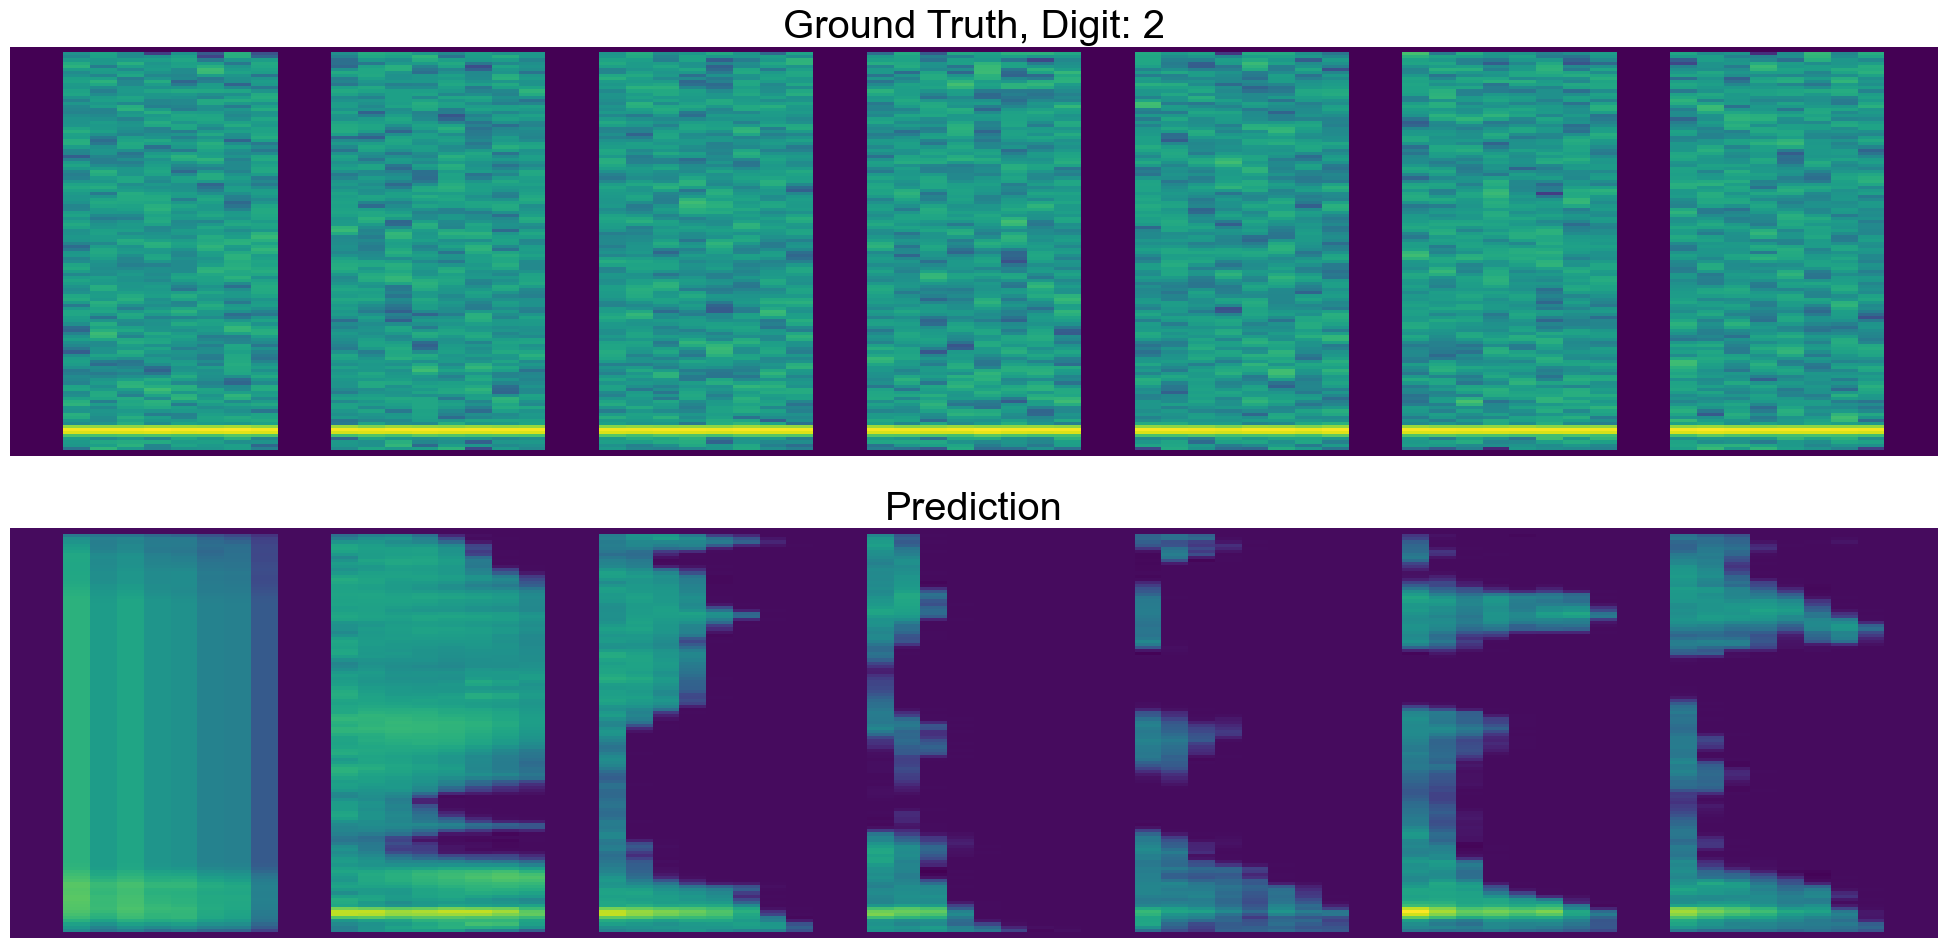

In [84]:
n=7
plt.rcParams['figure.facecolor'] = 'white'

savefigs=False
GT = np.squeeze(batch.detach().numpy())
fmGT = torch.FloatTensor(GT[n]).unsqueeze(1)
fmP = torch.FloatTensor(FM_Pred[n]).unsqueeze(1)
GT_Grid = torchvision.utils.make_grid(fmGT[:,:,:,8:],nrow=netparams['TimeSize'])
P_Grid = torchvision.utils.make_grid(fmP[:,:,:,8:],nrow=netparams['TimeSize'])


fig1, axs = plt.subplots(2, 1, figsize = (20,10))
axs[0].imshow(GT_Grid[0], aspect='auto',  origin='lower') #cmap='gray'
axs[0].axis('off')
axs[0].set_title('Ground Truth, Digit: {:d}'.format(labels_train['digits'][n]))
axs[1].imshow(P_Grid[0],  aspect='auto',  origin='lower') #cmap='gray'
axs[1].axis('off')
axs[1].set_title('Prediction')
plt.tight_layout()
plt.show()
if savefigs:
    fig1.savefig(os.path.join(FigurePath,'GT_Pred_{:d}.pdf'.format(n)), facecolor=fig1.get_facecolor(), transparent=True)


In [53]:
for key in h_tr.keys():
    print(h_tr[key].shape, h_tr[key].shape[-1]*h_tr[key].shape[-2]*h_tr[key].shape[-3])

(2048, 7, 4, 128, 16) 8192
(2048, 7, 16, 64, 8) 8192
(2048, 7, 64, 32, 4) 8192
(2048, 7, 256, 16, 2) 8192


In [42]:
8*128*32, 64*64*4

(32768, 16384)

## PCA

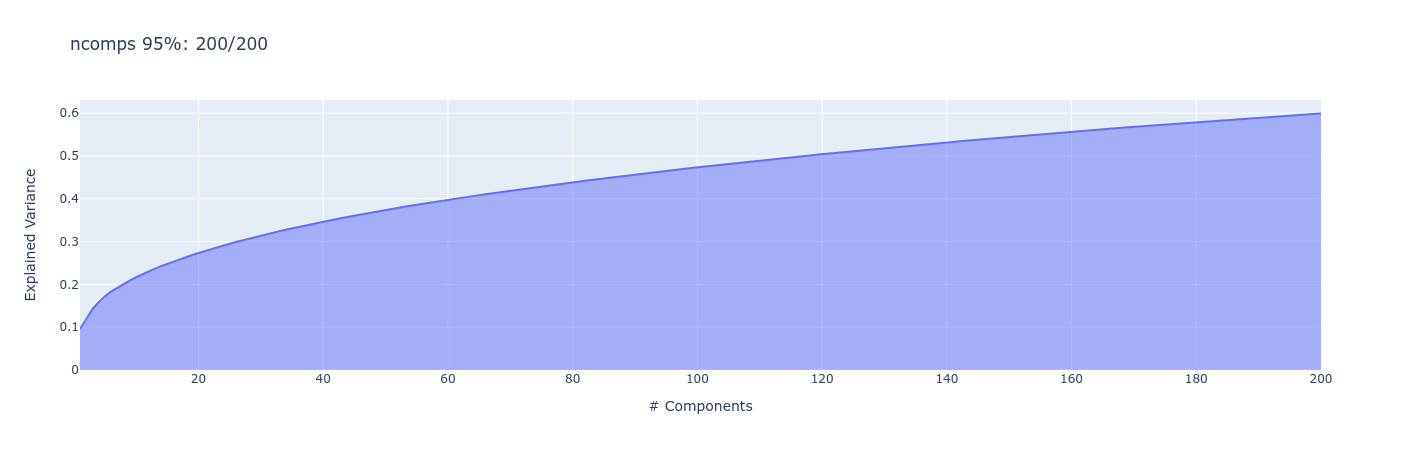

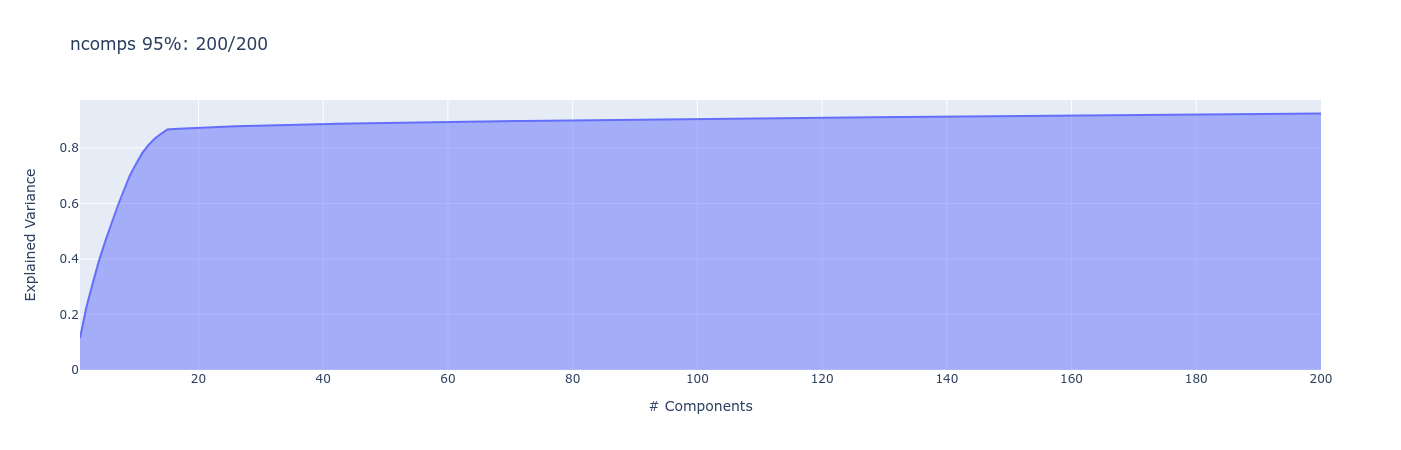

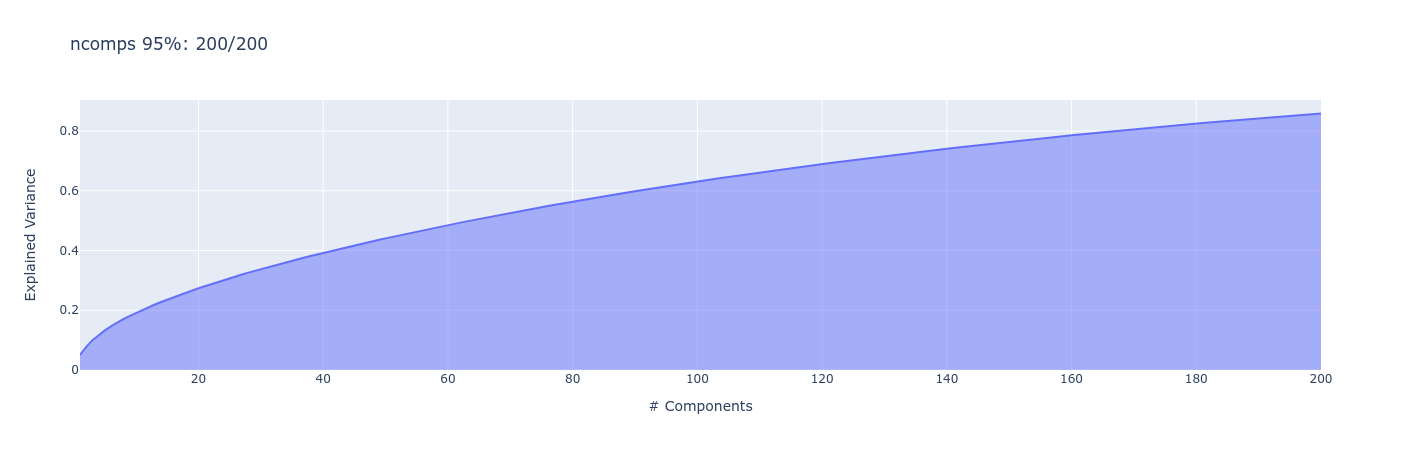

In [85]:
N_comp=200
layer = 2
pcaL = PCA(n_components=N_comp)
zcomps = pcaL.fit_transform(h_tr['h{:d}'.format(layer)][:,-1].reshape(tot_train,-1))

exp_var_cumul = np.cumsum(pcaL.explained_variance_ratio_)
fig = px.area(x=range(1, exp_var_cumul.shape[0] + 1),
        y=exp_var_cumul,
        labels={"x": "# Components", "y": "Explained Variance"},
        title='ncomps 95%: {}/{}'.format(len(exp_var_cumul[exp_var_cumul<.95]),N_comp)
        )
fig.show()

N_comp=200
layer = 2
pcaL = PCA(n_components=N_comp)
zcomps = pcaL.fit_transform(h_te['h{:d}'.format(layer)][:,-1].reshape(tot_train,-1))

exp_var_cumul = np.cumsum(pcaL.explained_variance_ratio_)
fig = px.area(x=range(1, exp_var_cumul.shape[0] + 1),
        y=exp_var_cumul,
        labels={"x": "# Components", "y": "Explained Variance"},
        title='ncomps 95%: {}/{}'.format(len(exp_var_cumul[exp_var_cumul<.95]),N_comp)
        )
fig.show()

N_comp=200
layer = 2
pcaL = PCA(n_components=N_comp)
zcomps = pcaL.fit_transform(h_pure['h{:d}'.format(layer)][:,-1].reshape(tot_pure,-1))

exp_var_cumul = np.cumsum(pcaL.explained_variance_ratio_)
fig = px.area(x=range(1, exp_var_cumul.shape[0] + 1),
        y=exp_var_cumul,
        labels={"x": "# Components", "y": "Explained Variance"},
        title='ncomps 95%: {}/{}'.format(len(exp_var_cumul[exp_var_cumul<.95]),N_comp)
        )
fig.show()

In [86]:

def PCA_States(ht,netparams,labels_df,tot_trials,FigPath,N_comp=30,savefigs=False,Type='Train'):
    ztot = []
    for layer in range(len(netparams['R_stack_sizes'])):
        pcaL = PCA(n_components=N_comp)
        zcomps = pcaL.fit_transform(ht['h{:d}'.format(layer)][:,:].reshape(tot_trials,-1))
        ztot.append(zcomps)
        exp_var_cumul = np.cumsum(pcaL.explained_variance_ratio_)
        fig = px.area(x=range(1, exp_var_cumul.shape[0] + 1),
                y=exp_var_cumul,
                labels={"x": "# Components", "y": "Explained Variance"},
                title='ncomps 95%: {}/{}'.format(len(exp_var_cumul[exp_var_cumul<.95]),N_comp)
                )
    #     fig.show()
        if savefigs:

            labels = {
                str(i): f"PC {i+1} ({var:.1f}%)"
                for i, var in enumerate(pcaL.explained_variance_ratio_ * 100)
            }

            fig2 = px.scatter_matrix(
                zcomps,
                labels=labels,
                dimensions=range(2),
                color=labels_df['digits'],

            )
            fig2.update_traces(diagonal_visible=False)
            fig2.update_layout(autosize=False,
                              coloraxis_colorbar=dict(title='Time'),
                              width=1000,
                              height=1000,
                              )
            fig.write_image(os.path.join(check_path(FigPath,Type),'ExplainedVar_L{:d}_Trial{}.png'.format(layer,Trial)))
            fig2.write_image(os.path.join(check_path(FigPath,Type),'PCAMat_L{:d}_Trial{}.png'.format(layer,Trial)))
    return ztot

In [12]:
N_comp=9
FigPath = check_path(FigurePath,'{}'.format(netparams['filename']))
savefigs = False
ztot_tr = PCA_States(h_tr,netparams,labels_train,tot_train,FigPath,N_comp=N_comp,savefigs=True,Type='Train_LogScale')
ztot_te = PCA_States(h_te,netparams,labels_test,tot_test,FigPath,N_comp=N_comp,savefigs=True,Type='Test_LogScale')
ztot_pure = PCA_States(h_pure,netparams,labels_pure_df,tot_pure,FigPath,N_comp=N_comp,savefigs=True,Type='Pure_LogScale')

In [ ]:
layer=0
labels = {
    str(i): f"PC {i+1} ({var:.1f}%)"
    for i, var in enumerate(pcaL.explained_variance_ratio_ * 100)
}

fig = px.scatter_matrix(
    ztot_tr[layer],
    labels=labels_test,
    dimensions=range(4),
    color=labels_train['digits'],
   
)
fig.update_traces(diagonal_visible=False)
fig.update_layout(autosize=False,
                  coloraxis_colorbar=dict(title='Time'),
                  width=1000,
                  height=1000,
                  )
fig.show()

In [ ]:
layer=3
fig = go.Figure(data=[go.Scatter3d(x=ztot_tr[layer][:,0], y=ztot_tr[layer][:,1], z=ztot_tr[layer][:,2],
                                   mode='markers',
                                   marker=dict(
                                                size=5,
                                                color= pd.factorize(labels_train['speaker'])[0], # labels_train['digits'], # pd.factorize(labels_test['speaker'])[0], #
                                                colorbar=dict(title='Digit'),
                                                opacity=0.8),
#                                    line=dict(
#                                              color=np.arange(zcomps[t:t+dt,0].shape[0])/30,
#                                              width=2)
                                   )])
fig.update_layout(autosize=False,
                  coloraxis_colorbar=dict(title='Time (s)'),
                  width=500,
                  height=500,
                  )
fig.show()

## Linear Regression Testing

In [8]:
from sklearn.linear_model import LogisticRegression
from sklearn import datasets, svm, metrics
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_classification

In [9]:
# layer = 3
data_type = 'PCA'
def train_classifer(data,ht,labels,netparams,tot_trials,data_type=data_type):
    scores = []
    for layer in range(len(netparams['R_stack_sizes'])):
        if data_type == 'PCA':
            X = data[layer]
        else:
            X = ht['h{:d}'.format(layer)][:,1].reshape(tot_trials,-1) #  

        clf = make_pipeline(StandardScaler(),
#                             LinearSVC(random_state=0, tol=1e-5, max_iter=10000),)
                            LogisticRegression(random_state=0, tol=1e-5, max_iter=10000,n_jobs=-1)) # 

        # Split data into 50% train and 50% test subsets
        X_train, X_test, y_train, y_test = train_test_split(X, labels, test_size=0.5, shuffle=False, random_state=1)

        # Learn the digits on the train subset
        clf.fit(X_train, y_train)

        predicted = clf.predict(X_test)
        scores.append(metrics.accuracy_score(y_test, predicted))
#         print('Layer: {}, Score: {}'.format(layer, scores[layer]))
    print('Diff Score: {:.04}'.format(scores[-1]-scores[0]))
#         print(f"Classification report for classifier layer{layer} {clf}:\n"
#               f"{metrics.classification_report(y_test, predicted)}\n")
    return scores


In [81]:
scores_tr = train_classifer(ztot_tr,h_tr,labels_train['digits'].to_numpy(),netparams,tot_train,data_type='PCA')
scores_te = train_classifer(ztot_te,h_te,labels_test['digits'].to_numpy(),netparams,tot_test,data_type='PCA')
scores_pure = train_classifer(ztot_pure,h_pure,labels_pure_df['digits'].to_numpy(),netparams,tot_pure,data_type='PCA')


  0%|          | 0/4 [00:00<?, ?it/s]

Layer: 0, Score: 0.412109375
Layer: 1, Score: 0.2958984375
Layer: 2, Score: 0.431640625
Layer: 3, Score: 0.5380859375


  0%|          | 0/4 [00:00<?, ?it/s]

Layer: 0, Score: 0.40625
Layer: 1, Score: 0.33035714285714285
Layer: 2, Score: 0.4732142857142857
Layer: 3, Score: 0.49776785714285715


  0%|          | 0/4 [00:00<?, ?it/s]

Layer: 0, Score: 0.93125
Layer: 1, Score: 0.4625
Layer: 2, Score: 0.646875
Layer: 3, Score: 0.515625


In [38]:
ztot_tr2 = np.hstack(ztot_tr)
ztot_te2 = np.hstack(ztot_te)
ztot_pure2 = np.hstack(ztot_pure)

In [10]:
# layer = 3
data_type = 'PCA'
def train_classifer_compiled(X,ht,labels,netparams,tot_trials,data_type=data_type):
    scores = []
    clf = make_pipeline(StandardScaler(),
#                             LinearSVC(random_state=0, tol=1e-5, max_iter=10000),)
                        LogisticRegression(random_state=0, tol=1e-5, max_iter=10000,n_jobs=-1)) # 

    # Split data into 50% train and 50% test subsets
    X_train, X_test, y_train, y_test = train_test_split(X, labels, test_size=0.2, shuffle=False, random_state=1)

    # Learn the digits on the train subset
    clf.fit(X_train, y_train)

    predicted = clf.predict(X_test)
    scores.append(metrics.accuracy_score(y_test, predicted))
    print('Layer: all, Score: {}'.format(scores))
#         print(f"Classification report for classifier layer{layer} {clf}:\n"
#               f"{metrics.classification_report(y_test, predicted)}\n")
    return scores


In [82]:
scores_tr2 = train_classifer_compiled(ztot_tr2,h_tr,labels_train['digits'].to_numpy(),netparams,tot_train,data_type='PCA')
scores_te2 = train_classifer_compiled(ztot_te2,h_te,labels_test['digits'].to_numpy(),netparams,tot_test,data_type='PCA')
scores_pure2 = train_classifer_compiled(ztot_pure2,h_pure,labels_pure_df['digits'].to_numpy(),netparams,tot_pure,data_type='PCA')


Layer: all, Score: [0.8]
Layer: all, Score: [0.7611111111111111]
Layer: all, Score: [0.921875]


In [84]:
scores_tr = np.array(scores_tr)
scores_te = np.array(scores_te)
scores_pure = np.array(scores_pure)

(0,
 Unnamed: 0       0
 digits        1000
 Trial            0
 Name: 0, dtype: int64)

In [43]:
labels_pure_df2 = pd.DataFrame(columns=labels_pure_df.columns)
for ind,row in labels_pure_df.iterrows():
    if row['digits'] in labels_pure_df['digits'].unique()[::2]:
        labels_pure_df2=labels_pure_df2.append(row)
    

# Create Grant Figures

In [96]:
FigPath = check_path(FigurePath,'{}'.format(netparams['filename']))
labels = 'speaker'
check_path(FigPath,labels)
for N_comp in range(1,20):
    print('N_comp={}'.format(N_comp))
#     ztot_tr = PCA_States(h_tr,netparams,labels_train,tot_train,FigPath,N_comp=N_comp,savefigs=False,Type='Train_LogScale')
    ztot_te = PCA_States(h_te,netparams,labels_test,tot_test,FigPath,N_comp=N_comp,savefigs=False,Type='Test_LogScale')
    ztot_pure = PCA_States(h_pure,netparams,labels_pure_df,tot_pure,FigPath,N_comp=N_comp,savefigs=False,Type='Pure_LogScale')

#     scores_tr = train_classifer(ztot_tr,h_tr,labels_train[labels].to_numpy(),netparams,tot_train,data_type='PCA')
    scores_te = train_classifer(ztot_te,h_te,labels_test[labels].to_numpy(),netparams,tot_test,data_type='PCA')
    scores_pure = train_classifer(ztot_pure,h_pure,labels_pure_df['digits'].to_numpy(),netparams,tot_pure,data_type='PCA')
    scores_te = np.array(scores_te)
    scores_pure = np.array(scores_pure)

#     ztot_tr2 = np.hstack(ztot_tr)
    ztot_te2 = np.hstack(ztot_te)
    ztot_pure2 = np.hstack(ztot_pure)

#     scores_tr2 = train_classifer_compiled(ztot_tr2,h_tr,labels_train[labels].to_numpy(),netparams,tot_train,data_type='PCA')
    scores_te2 = train_classifer_compiled(ztot_te2,h_te,labels_test[labels].to_numpy(),netparams,tot_test,data_type='PCA')
    scores_pure2 = train_classifer_compiled(ztot_pure2,h_pure,labels_pure_df['digits'].to_numpy(),netparams,tot_pure,data_type='PCA')


    fig, ax = plt.subplots(1,figsize=(12,5))
    ax.bar([1,2],scores_te[[0,-1]],color='b',label='Spoken Digits')
    ax.bar([4,5],scores_pure[[0,-1]],color='g', label='Pure Tones')
    ax.axhline(y=1/len(np.unique(labels_train[labels])),linestyle='--', color='red')
    ax.bar(7,scores_te2,color='b',)
    ax.bar(8,scores_pure2,color='g',)
    ax.set_ylim(0,1.1)
    ax.legend(bbox_to_anchor=(1.01, 1))
    ax.set_xlabel('Layer #')
    ax.set_ylabel('Accuracy')
    ax.set_xticks(np.arange(9))
    ax.set_xticklabels(['','1','4','','1','4','','all','all'])
    # ax.set_title('Labels=Digits')
    plt.tight_layout()
#     plt.show()
    fig.savefig(os.path.join(FigPath,labels,'LogisticReg_Accuracy_{}_LogScale_PCA{:d}_withALL_{}.pdf'.format(data_type,N_comp,labels)))


    fig, ax = plt.subplots(1,figsize=(12,5))
    ax.bar([1,2],scores_te[[0,-1]],color='b',label='Spoken Digits')
    ax.bar([4,5],scores_pure[[0,-1]],color='g', label='Pure Tones')
    ax.axhline(y=1/len(np.unique(labels_train[labels])),linestyle='--', color='red')
#     ax.set_ylim(0,1.1)
    ax.legend(bbox_to_anchor=(1.01, 1))
    ax.set_xlabel('Layer #')
    ax.set_ylabel('Accuracy')
    ax.set_xticks(np.arange(6))
    ax.set_xticklabels(['','1','4','','1','4'])
    # ax.set_title('Labels=Digits')
    plt.tight_layout()
#     plt.show()

    fig.savefig(os.path.join(FigPath,labels,'LogisticReg_Accuracy_{}_LogScale_PCA{:d}_{}.pdf'.format(data_type,N_comp,labels)))


    fig, ax = plt.subplots(1,figsize=(10,5))
    ax.plot(scores_te, 'b.-',markersize=20, linewidth=3)
    ax.plot(scores_pure, 'g.-',markersize=20, linewidth=3)
    ax.axhline(y=1/len(np.unique(labels_train[labels])),linestyle='--', color='red')
    ax.plot(4,scores_te2, 'r.-',markersize=20, linewidth=3)
    ax.plot(4,scores_pure2, 'g.-',markersize=20, linewidth=3)
    ax.set_ylim(0,1.1)
    ax.legend(['Test','Pure Tones','Random'],bbox_to_anchor=(1.01, 1))
    ax.set_xlabel('Layer #')
    ax.set_ylabel('Accuracy')
    ax.set_xticks(np.arange(5))
    ax.set_xticklabels(['0','1','2','3','all'])
    ax.set_title('Labels=Digits')
    plt.tight_layout()
#     plt.show()
    fig.savefig(os.path.join(FigPath,labels,'LogisticReg_Accuracy_{}_LogScale_PCA{:d}_Scatter_{}.pdf'.format(data_type,N_comp,labels)))


N_comp=1
Diff Score: 0.1138
Diff Score: -0.025
Layer: all, Score: [0.5055555555555555]
Layer: all, Score: [0.328125]
N_comp=2
Diff Score: 0.1696
Diff Score: -0.1063
Layer: all, Score: [0.6166666666666667]
Layer: all, Score: [0.828125]
N_comp=3
Diff Score: 0.06027
Diff Score: -0.2812
Layer: all, Score: [0.75]
Layer: all, Score: [0.9375]
N_comp=4
Diff Score: 0.0558
Diff Score: -0.3688
Layer: all, Score: [0.8055555555555556]
Layer: all, Score: [0.96875]
N_comp=5
Diff Score: 0.0625
Diff Score: -0.3813
Layer: all, Score: [0.8111111111111111]
Layer: all, Score: [0.984375]
N_comp=6
Diff Score: 0.08482
Diff Score: -0.3938
Layer: all, Score: [0.8666666666666667]
Layer: all, Score: [0.984375]
N_comp=7
Diff Score: 0.08929
Diff Score: -0.4187
Layer: all, Score: [0.8888888888888888]
Layer: all, Score: [0.984375]
N_comp=8
Diff Score: 0.09375
Diff Score: -0.4437
Layer: all, Score: [0.8944444444444445]
Layer: all, Score: [0.96875]
N_comp=9
Diff Score: 0.1004
Diff Score: -0.4875
Layer: all, Score: [0.8

Some difference in decoding accuracy across layers and is different for different type of stimuli. 

Pure tone input to trained PreCnet, want decoding in first layer to be the highest. 

In [20]:
ztot_pure.shape

(4, 640, 15)

Confusion matrix:
[[112   4   7   8  19  14]
 [  2 180   0   0   6   0]
 [  7   0 158   1   7   0]
 [  3   4   0 157   1   2]
 [ 17  14   3   4 130   6]
 [  6   3   1   0   5 143]]


<Figure size 1440x1440 with 0 Axes>

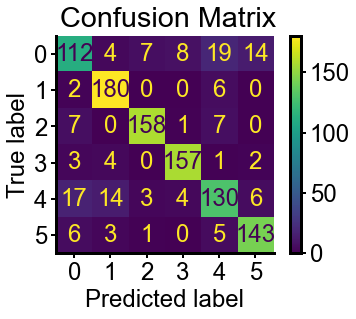

In [24]:
fig = plt.figure(figsize=(20,20))
disp = metrics.plot_confusion_matrix(clf, X_test, y_test)
disp.figure_.suptitle("Confusion Matrix")
print(f"Confusion matrix:\n{disp.confusion_matrix}")

plt.show()

In [ ]:
clf = LogisticRegressionCV(cv=2, random_state=0, n_jobs=-1).fit(X, y)
# clf.predict(X[:2, :])

# clf.predict_proba(X[:2, :]).shape

# clf.score(X, y)

# Pure Tones

In [58]:
import torchvision.transforms as TV
import torchaudio.transforms as AV

In [59]:
import librosa

def plot_spectrogram(spec, title=None, ylabel='freq_bin', aspect='auto', xmax=None):
    fig, axs = plt.subplots(1, 1)
    axs.set_title(title or 'Spectrogram (db)')
    axs.set_ylabel(ylabel)
    axs.set_xlabel('frame')
    im = axs.imshow(librosa.power_to_db(spec), origin='lower', aspect=aspect)
    if xmax:
        axs.set_xlim((0, xmax))
    fig.colorbar(im, ax=axs)
    plt.show(block=False)

In [44]:
np.logspace(1,4,10,base=10)

array([   10.        ,    21.5443469 ,    46.41588834,   100.        ,
         215.443469  ,   464.15888336,  1000.        ,  2154.43469003,
        4641.58883361, 10000.        ])

In [73]:


sig=.4
f = 1
phase = 0
ntones = 5
toneslist = [n*1000 for n in range(1,ntones+1)]
ntrials = 64
nsamples = 9000
times = np.linspace(0,2,nsamples)
tones = np.zeros((ntrials,ntones,nsamples))
labels_pure = np.zeros((ntrials,ntones,1))
amod = 5*np.random.rand(ntrials,ntones)

freq, trials, = [], []
for trial in trange(ntrials):
    for n, f in enumerate(toneslist):
        tones[trial,n] = amod[trial,n]*np.sin(f/(2*np.pi)*times + phase) + np.random.normal(loc=0,scale=sig,size=(nsamples))
        freq.append(f)
        trials.append(trial)
labels_pure_df = pd.DataFrame({'digits':freq,'Trial':trials})


  0%|          | 0/64 [00:00<?, ?it/s]

In [74]:
tones.shape

(64, 5, 9000)

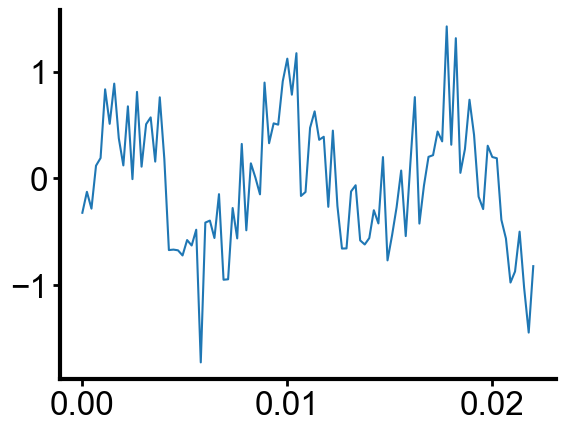

In [75]:
plt.plot(times[:100],tones[0,-1,:100])
plt.show()

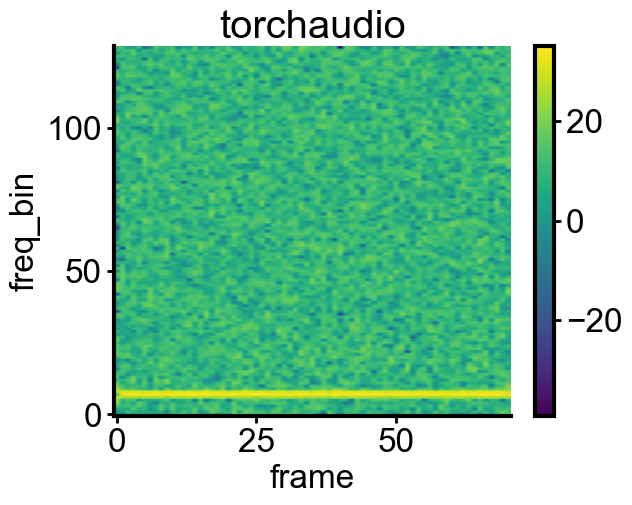

torch.Size([129, 71])


In [76]:
n_fft = 256
win_length = None
hop_length = 128

# define transformation
spects = AV.Spectrogram(
    n_fft=n_fft,
    win_length=win_length,
    hop_length=hop_length,
#     center=True,
#     pad_mode="reflect",
#     power=2.0,
)
# Perform transformation
spec = spects(torch.tensor(tones[0,-1],dtype=torch.float32))

# print_stats(spec)
plot_spectrogram(spec, title='torchaudio')
print(spec.shape)

In [77]:
nf,nt = (128,71)
resize = TV.Resize((nf,nt))
tones2 = tones.reshape(-1,nsamples)
data_spec1 = np.zeros((tones2.shape[0],1,nf,nt))
for n in range(tones2.shape[0]):
    mfcc = spects(torch.tensor(tones2[n],dtype=torch.float32)).numpy() #mfcc_transform
#     mfcc = mfcc_transform(torch.tensor(data1[n],dtype=torch.float32)).numpy() #mfcc_transform
    spec2 = resize(torch.Tensor(mfcc).unsqueeze(0))
    data_spec1[n,:] = librosa.power_to_db(spec2.numpy()) 


In [79]:
np.save(os.path.join(rootdir,'Specs_puretones_logscale_speaker.npy'),data_spec1)
labels_pure_df.to_csv(os.path.join(rootdir,'labels_puretones_logscale_speaker.csv'))

## Grab States for Pure Tones

In [55]:
labels_pure_df = pd.read_csv(os.path.join(rootdir,'labels_puretones.csv'))
initial_states = precnet.get_initial_states(input_shape)
states = initial_states
ht_pure = {'h{:d}'.format(n):[] for n in range(len(netparams['R_stack_sizes']))}
with torch.no_grad():
    for batch in tqdm(DataLoader_Pure):
        output, states, frame_pred = precnet.grab_states(batch.to(device), states, grab_frame=True)
        for n, state in enumerate(states[:len(netparams['R_stack_sizes'])]):
            ht_pure['h{:d}'.format(n)].append(output['h{:d}'.format(n)])
        initial_states = precnet.get_initial_states(input_shape)
        states = initial_states
for n in range(len(netparams['R_stack_sizes'])):
     ht_pure['h{:d}'.format(n)] = np.stack(ht_pure['h{:d}'.format(n)]).transpose(0,2,1,3,4,5).reshape((-1,netparams['TimeSize'],) + ht_pure['h{:d}'.format(n)][0].shape[-3:])

  0%|          | 0/10 [00:00<?, ?it/s]

In [32]:
FigPath

'/home/eabe/Research/PredAudio/Figures/PreCNetGRU_T007_N08_E1500_Tau01_Visual'

In [56]:
tot_pure = len(Dataset_Pure)
N_comp=200
FigPath = check_path(FigurePath,'{}'.format(netparams['filename']))
savefigs = True
ztot = []
for layer in trange(len(netparams['R_stack_sizes'])):
    pcaL = PCA(n_components=N_comp)
    zcomps = pcaL.fit_transform(ht['h{:d}'.format(layer)][:,:].reshape(tot_pure,-1))
    ztot.append(zcomps)
    exp_var_cumul = np.cumsum(pcaL.explained_variance_ratio_)
    fig = px.area(x=range(1, exp_var_cumul.shape[0] + 1),
            y=exp_var_cumul,
            labels={"x": "# Components", "y": "Explained Variance"},
            title='ncomps 95%: {}/{}'.format(len(exp_var_cumul[exp_var_cumul<.95]),N_comp)
            )
#     fig.show()
    
    labels = {
        str(i): f"PC {i+1} ({var:.1f}%)"
        for i, var in enumerate(pcaL.explained_variance_ratio_ * 100)
    }

    fig2 = px.scatter_matrix(
        zcomps,
        labels=labels,
        dimensions=range(4),
        color=labels_pure_df['Freq'],

    )
    fig2.update_traces(diagonal_visible=False)
    fig2.update_layout(autosize=False,
                      coloraxis_colorbar=dict(title='Time'),
                      width=1000,
                      height=1000,
                      )
    if savefigs:
        fig.write_image(os.path.join(FigPath,'ExplainedVar_L{:d}_Trial{}_PureTones.png'.format(layer,Trial)))
        fig2.write_image(os.path.join(FigPath,'PCAMat_L{:d}_Trial{}_PureTones.png'.format(layer,Trial)))


  0%|          | 0/4 [00:00<?, ?it/s]

In [57]:
# layer = 3
scores = []
for layer in trange(len(netparams['R_stack_sizes'])):
    X = ztot[layer]#  ht['h{:d}'.format(layer)][:,1].reshape(tot_pure,-1) # 
#     y = labels_train['digits'].to_numpy()

    # clf = svm.LinearSVC(max_iter=5000)
    clf = make_pipeline(StandardScaler(),
                        LinearSVC(random_state=0, tol=1e-5, max_iter=10000)) # 

    labels = labels_pure_df['Freq'].to_numpy()# pd.factorize(labels_train['speaker'])[0] # 
    # Split data into 50% train and 50% test subsets
    X_train, X_test, y_train, y_test = train_test_split(
        X, labels, test_size=0.5, shuffle=False, random_state=1)

    # Learn the digits on the train subset
    clf.fit(X_train, y_train)

    predicted = clf.predict(X_test)
    scores.append(metrics.accuracy_score(y_test, predicted))

    print(f"Classification report for classifier layer{layer} {clf}:\n"
          f"{metrics.classification_report(y_test, predicted)}\n")


  0%|          | 0/4 [00:00<?, ?it/s]

Classification report for classifier layer0 Pipeline(steps=[('standardscaler', StandardScaler()),
                ('linearsvc',
                 LinearSVC(max_iter=10000, random_state=0, tol=1e-05))]):
              precision    recall  f1-score   support

           1       0.97      1.00      0.98        32
           2       0.97      0.97      0.97        32
           3       0.97      1.00      0.98        32
           4       1.00      0.97      0.98        32
           5       0.97      0.97      0.97        32
           6       1.00      0.97      0.98        32
           7       0.97      1.00      0.98        32
           8       1.00      0.97      0.98        32
           9       1.00      0.97      0.98        32
          10       0.97      1.00      0.98        32

    accuracy                           0.98       320
   macro avg       0.98      0.98      0.98       320
weighted avg       0.98      0.98      0.98       320


Classification report for classifier l

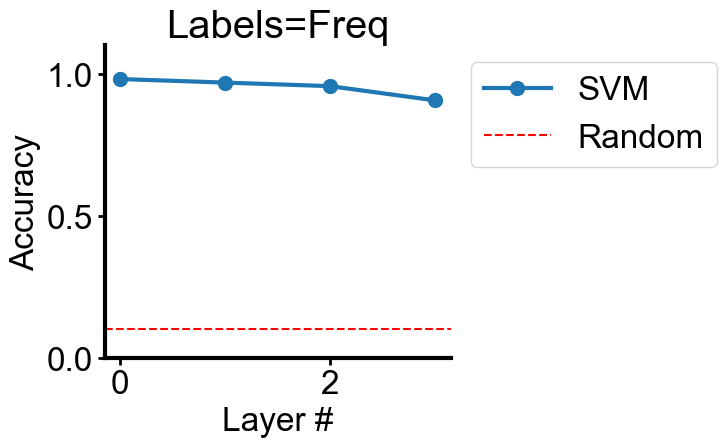

In [70]:
fig, ax = plt.subplots(1,figsize=(8,5))
ax.plot(scores, '.-',markersize=20, linewidth=3)
ax.axhline(y=1/len(np.unique(y_test)),linestyle='--', color='red')
ax.set_ylim(0,1.1)
ax.legend(['SVM','Random'],bbox_to_anchor=(1.01, 1))
ax.set_xlabel('Layer #')
ax.set_ylabel('Accuracy')
ax.set_title('Labels=Freq')
plt.tight_layout()
plt.show()
fig.savefig(os.path.join(FigPath,'SVM_Accuracy_PureTones.png'))

# Feature Visualization 

In [13]:

import torchvision.transforms as T


In [20]:
list(map(lambda x: x[0], precnet.hd.named_children()))


['0', '1', '2', '3']

In [21]:
precnet

PreCNet(
  (hd): ModuleList(
    (0): Conv2d(12, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): Conv2d(48, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (2): Conv2d(192, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (zd): ModuleList(
    (0): Conv2d(12, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): Conv2d(48, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (2): Conv2d(192, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (od): ModuleList(
    (0): Conv2d(12, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): Conv2d(48, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (2): Conv2d(192, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (hu): Modul

In [22]:
# We will register a forward hook to get the output of the layers

activation = {} # to store the activation  of a layer
def create_hook(name):
    def hook(m, i, o):
        # copy the output of the given layer
        activation[name] = o
       
    return hook


# register a forward hook for layer inception4a i.e. the first inception layer
precnet.hd.register_forward_hook(create_hook('0'))

In [23]:


normalize = T.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])


# undo the above normalization if and when the need arises 
denormalize = T.Normalize(mean = [-0.485/0.229],  #, -0.456/0.224, -0.406/0.225],
                                   std = [1/0.229])  #, 1/0.224, 1/0.225] )

def random_image(Height = 28, Width = 28, device = 'cpu', requires_grad=False, optimizer=None, lr = 0.01):
    img = np.single(np.random.uniform(0,1, (16, Height, Width))) # we need the pixel values to be of type float32
    im_tensor = torch.from_numpy(img).to(device).requires_grad_(requires_grad) # normalize the image to have requisite mean and std. dev.
    print("img_shape:{}, img_dtype: {}".format(im_tensor.shape, im_tensor.dtype ))
    
    if optimizer:
        if requires_grad:
            return im_tensor, optimizer([im_tensor], lr = lr)
        else: 
            print('Error: Optimizer cannot be used on an image without setting its requires_grad_  ')
    
    return im_tensor

In [24]:

# function to massage img_tensor for using as input to plt.imshow()
def image_converter(im):
    
    # move the image to cpu
    im_copy = im.cpu()
    
    # for plt.imshow() the channel-dimension is the last
    # therefore use transpose to permute axes
    im_copy = im_copy.clone().detach().numpy().transpose(1,2,0)
    # clip negative values as plt.imshow() only accepts 
    # floating values in range [0,1] and integers in range [0,255]
    im_copy = im_copy.clip(0, 1) 
    
    return im_copy

In [25]:
# class to compute image gradients in pytorch
class gradients(nn.Module):
    def __init__(self, weight):
        super().__init__()
        k_depth, k_height, k_width = weight.shape[2:]
        # assuming that the height and width of the kernel are always odd numbers
        padding_x = int((k_height-1)/2)
        padding_y = int((k_width-1)/2)
        padding_z = int((k_depth-1)/2)
        
        # convolutional layer with 2 output channels corresponding to the x and the y gradients
        self.conv = nn.Conv3d(1, 2, (k_depth,k_height, k_width), bias = False, 
                              padding = (padding_z, padding_x, padding_y) )
        # initialize the weights of the convolutional layer to be the one provided
        if self.conv.weight.shape == weight.shape:
            self.conv.weight = nn.Parameter(weight)
            self.conv.weight.requires_grad_(False)
        else:
            print('Error: The shape of the given weights is not correct')
    
    def forward(self, x):
        return self.conv(x)

In [26]:
gradLayer = gradients(torch.from_numpy(grad_filters).unsqueeze(1).type(torch.FloatTensor))


NameError: name 'grad_filters' is not defined

In [27]:
H = 64 # height of input image
W = 64 # width of input image
img_tensor, optimizer = random_image(Height = H, Width = W, device = device, 
                                     requires_grad = True, optimizer = optim.Adam, lr = 0.01)

img_shape:torch.Size([16, 64, 64]), img_dtype: torch.float32


In [28]:
im_grid = torchvision.utils.make_grid(img_tensor.cpu().unsqueeze(1),nrow=4,normalize=True)
# # Starting Image
plt.imshow(im_grid.permute(1,2,0))                                                               
plt.axis('off')
# plt.title('starting image')
# plt.show()

(-0.5, 265.5, 265.5, -0.5)

In [29]:
# understanding the shape of the output produced by a given layer
image = img_tensor.clone().detach().to(device).requires_grad_(True)
model(image.unsqueeze(0).unsqueeze(0))
activation['conv0'].shape

NameError: name 'model' is not defined

epoch: 0/10000, activation: -0.15188148617744446


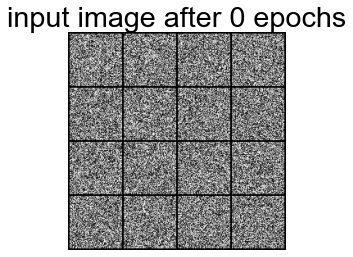

epoch: 1000/10000, activation: 15.133533477783203


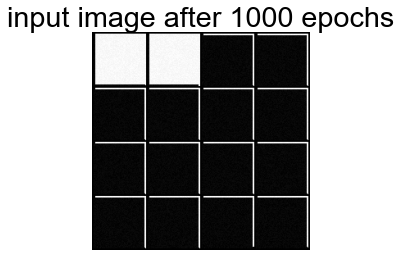

epoch: 2000/10000, activation: 30.418893814086914


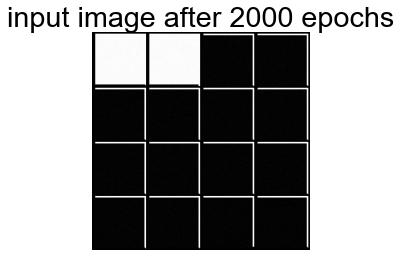

epoch: 3000/10000, activation: 45.70398712158203


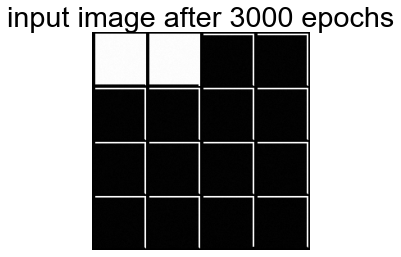

epoch: 4000/10000, activation: 60.98853302001953


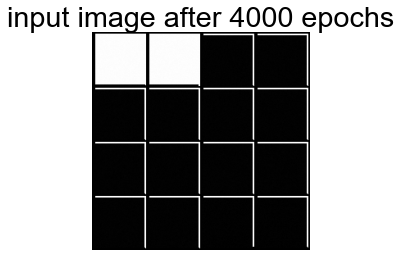

epoch: 5000/10000, activation: 76.27294921875


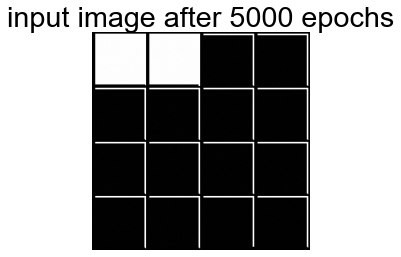

epoch: 6000/10000, activation: 91.55735778808594


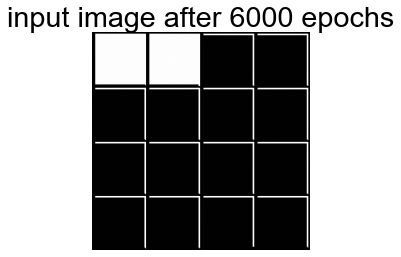

epoch: 7000/10000, activation: 106.84294128417969


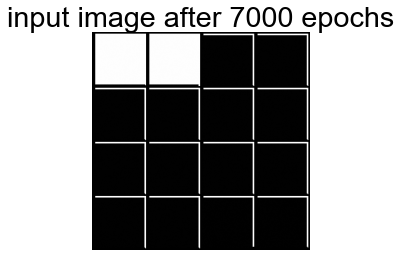

epoch: 8000/10000, activation: 122.12921142578125


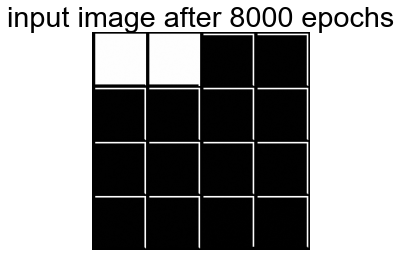

KeyboardInterrupt: 

In [97]:
model.eval()


num_epochs = 10000
display_every = 1000
unit_idx = 10 # unit of the convolution layer that we wish to visualize

for epoch in range(num_epochs):
    
    optimizer.zero_grad()
    model(img_tensor.unsqueeze(0).unsqueeze(0))
    layer_out = activation['conv0']
    loss = -layer_out[0, unit_idx].mean() 
    loss.backward()
    optimizer.step()
    # normalize the updated img_tensor to have pytorch specified mean and std. dev.
    # img_tensor = normalize(img_tensor.clone().detach()).requires_grad_(True)
    # the above step of renormalizing the updated img_tensor does not work: the activation remains frozen at ~ 2.368 and no patterns seem to develop in the image
    # Will have to understand this further  
    
    if epoch % display_every == 0:
        print('epoch: {}/{}, activation: {}'.format(epoch, num_epochs, -loss))
        im_grid = torchvision.utils.make_grid(img_tensor.cpu().unsqueeze(1),nrow=4,normalize=True)
        plt.imshow(im_grid.permute(1,2,0))
        plt.axis('off')
        plt.title('input image after {} epochs'.format(epoch))
        plt.show()

In [ ]:
'''
forward pass through the model to get the scores, note that VGG-19 model doesn't perform softmax at the end
and we also don't need softmax, we need scores, so that's perfect for us.
'''

scores = model(X.to(device))[0]

# Get the index corresponding to the maximum score and the maximum score itself.
score_max_index = scores.argmax(axis=1)

In [36]:
score_max = scores[0,score_max_index]

'''
backward function on score_max performs the backward pass in the computation graph and calculates the gradient of 
score_max with respect to nodes in the computation graph
'''
score_max.backward()

'''
Saliency would be the gradient with respect to the input image now. But note that the input image has 3 channels,
R, G and B. To derive a single class saliency value for each pixel (i, j),  we take the maximum magnitude
across all colour channels.
'''
saliency, _ = torch.max(X.grad.data.abs(),dim=1)

# code to plot the saliency map as a heatmap
plt.imshow(saliency[0], cmap=plt.cm.hot)
plt.axis('off')
plt.show()

RuntimeError: CUDA out of memory. Tried to allocate 16.00 GiB (GPU 0; 10.76 GiB total capacity; 1.17 GiB already allocated; 7.67 GiB free; 1.23 GiB reserved in total by PyTorch)

In [35]:
del scores, score_max_index, X
torch.cuda.empty_cache()
gc.collect()

NameError: name 'scores' is not defined

In [16]:
score_max.shape

torch.Size([1, 16, 64, 64, 64, 64])

# Dataset Testing

In [2]:
class AudioDataset(Dataset):
    def __init__(self, data_path, wind_size=32, transform=None):
        
        self.data = np.load(data_path)
        self.wind_size = wind_size
        self.transform = transform
        

    def __len__(self):
        return(self.data.shape[0])
    
    def __getitem__(self,idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        sample = np.zeros((self.data.shape[-1]//self.wind_size,self.data.shape[-2],self.wind_size))
        for n in range(self.data.shape[-1]//self.wind_size):
            sample[n] = self.data[idx,:,:,(n*self.wind_size):(n*self.wind_size+self.wind_size)]
        sample = (sample - np.min(sample))/(np.max(sample)-np.min(sample))
        sample = np.clip(sample, 2e-30, 1).astype(np.float32)

        sample = torch.Tensor(sample[:,np.newaxis])

        if self.transform:
            sample = self.transform(sample)
            
        return sample

In [34]:
dataset = AudioDataset(data_path_train,wind_size)
train_dataloader = DataLoader(dataset,
                              batch_size= 60,
                              shuffle = False,
                              drop_last=False,
#                               num_workers=7,
                              pin_memory=False,)

NameError: name 'data_path_train' is not defined

In [271]:
batch = next(iter(train_dataloader))

In [279]:
batch.shape

torch.Size([8, 16, 1, 128, 32])

In [6]:
batch_iter = iter(DataLoader_Train)
batch = batch_iter.next()

In [8]:
batch.shape

torch.Size([64, 56, 1, 128, 16])

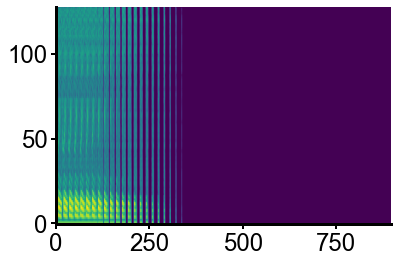

In [7]:
plt.imshow(np.hstack(batch[3,:,0]), aspect='auto', origin='lower')